In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import os
import copy
import tensorflow as tf

2025-11-25 16:17:55.909121: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 16:17:55.970584: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 16:17:55.971731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 16:17:56.909978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')
keras_advanced_utility = import_local_or_github('keras_advanced_utility', directory='../Utility')

extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

We begin assuming that we have the following measurements, which could come from a camera (ventral optic flow) and IMU. The acceleration measurements must be defined by the dynamics equations.

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[red]{\ddot{x}} \\[0.3em]
\bbox[red]{\ddot{z}} \\[0.3em]
\end{bmatrix} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix} +
\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m} \\[0.3em]
\end{bmatrix} \bbox[lightgreen]{j_2}
$

# Dynamics and measurement functions

In [4]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

In [5]:
print(f(None, None, return_state_names=True))

['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']


In [6]:
print(h(None, None, return_measurement_names=True))

['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']


# Run MPC simulation

In [7]:
# Note: this dt needs to match the dt from the generated data used to the train the ANN..
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, dt=0.1, tsim_length=20, trajectory_shape='squiggle', rterm=1e-1)

### plot the x, z trajectory

Text(0, 0.5, 'z pos')

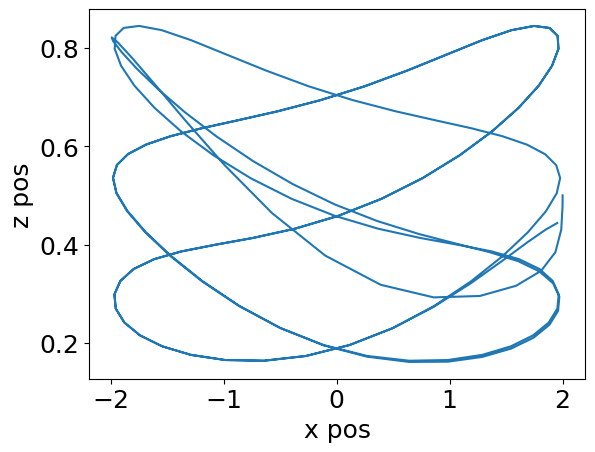

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [9]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

In [10]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='optic_flow'>

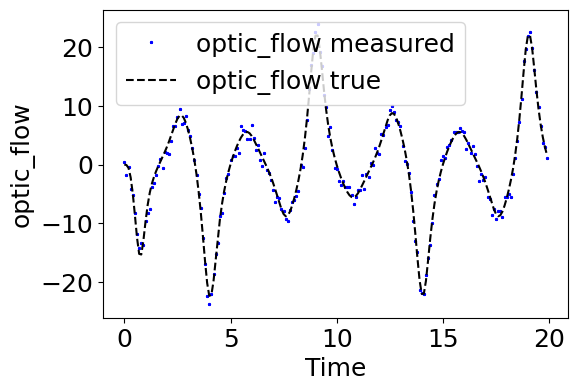

In [11]:
plot_tme(t_sim, y_sim['optic_flow'], y_noisy['optic_flow'], label_var='optic_flow')

In [12]:
#plot_tme(t_sim, y_sim['accel_x'], y_noisy['accel_x'], label_var='accel_x')

### Save data as dataframes

In [13]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Load data driven models

In [14]:
ls

A_keras_dynamics_model.ipynb
B_keras_measurement_model.ipynb
C_data_driven_UKF.ipynb
continuous_dynamics_simple.keras
curriculum_dropout_results.png
graph
graph.png
keras_helper_functions.py
old/
planar_drone_trajectories/
planar_drone_trajectories.zip
__pycache__/
smooth_dynamics_model_config.json
smooth_dynamics_model_continuous_config.json
smooth_dynamics_model_continuous_nojac_config.json
smooth_dynamics_model_continuous_nojac_weights.h5
smooth_dynamics_model_continuous_weights.h5
smooth_dynamics_model_weights.h5
smooth_measurements_model_config.json
smooth_measurements_model_weights.h5
trajectories/


### Dynamics model

In [15]:
model_weights = 'smooth_dynamics_model_continuous_weights.h5'
model_config = 'smooth_dynamics_model_continuous_config.json'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

dynamics_model, dropout_layer, measurements_config = keras_advanced_utility.load_model_complete('smooth_dynamics_model_continuous')

✓ Loaded configuration from: smooth_dynamics_model_continuous_config.json
✓ Model compiled with learning_rate=0.001
✓ Loaded weights from: smooth_dynamics_model_continuous_weights.h5

Model loaded successfully!
  Core input dim: 8
  Aux input dim: 8
  Jacobian weight: 1.0
  SV weight: 0.01


2025-11-25 16:18:45.101903: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Measurement model

In [16]:
model_weights = 'smooth_measurements_model_weights.h5'
model_config = 'smooth_measurements_model_config.json'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

measurements_model, dropout_layer, measurements_config = keras_advanced_utility.load_model_complete('smooth_measurements_model')

✓ Loaded configuration from: smooth_measurements_model_config.json
✓ Model compiled with learning_rate=0.001
✓ Loaded weights from: smooth_measurements_model_weights.h5

Model loaded successfully!
  Core input dim: 8
  Aux input dim: 8
  Jacobian weight: 0.1
  SV weight: 0.01


### Make fast inference models

In [17]:
# Make a fast inference model
dynamics_inference_model = keras_advanced_utility.create_fast_inference_model(dynamics_model)
measurements_inference_model = keras_advanced_utility.create_fast_inference_model(measurements_model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())
✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


### Wrap the models to take x, u

In [18]:
class DynamicsANN(object):
    def __init__(self, model):
        self.aux = None
        self.predict_dynamics = model

    def predict(self, x, u):
        X = np.atleast_2d(np.hstack((x, u)))
        X_tf = tf.constant(X)
        if self.aux is None:
            self.aux = tf.constant( np.atleast_2d(np.zeros_like(X)))
        xnew = self.predict_dynamics(X_tf, self.aux).numpy()
        #xnew = self.predict_dynamics(X_tf).numpy()
        return np.ravel(xnew)

In [19]:
# Wrap into a function with the same syntax as our original f(x, u)
dann_dynamics = DynamicsANN(dynamics_inference_model)
f_ann = dann_dynamics.predict

# Check to make sure it works
f_ann(np.random.normal(0, 1, 6), np.random.normal(0, 1, 2))

2025-11-25 16:18:50.942561: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xd59bd00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-25 16:18:50.942620: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-11-25 16:18:50.955220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 16:18:51.067503: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([  2.3225517 ,  20.22537   ,  -0.06466681,  -2.1890378 ,
         1.3594456 , -11.47198   ], dtype=float32)

In [20]:
# Wrap into a function with the same syntax as our original f(x, u)
dann_measurements = DynamicsANN(measurements_inference_model)
h_ann = dann_measurements.predict

# Check to make sure it works
h_ann(np.random.normal(0, 1, 6), np.random.normal(0, 1, 2))

array([ -1.8027798,   1.7631584,  -3.7458777,  -3.9005778, -12.6996155],
      dtype=float32)

### Validate f_ann function

In [21]:
state = 4

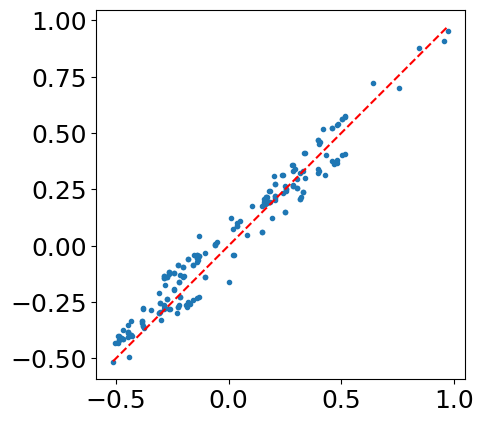

In [22]:
true = []
pred = []

for i in range(len(t_sim)):
    x = f(x_sim_df.values[i], u_sim_df.values[i])
    true.append(x)

    x = f_ann(x_sim_df.values[i], u_sim_df.values[i])
    pred.append(x)

true = np.vstack(true)
pred = np.vstack(pred)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(true[:,state], pred[:,state], '.')

l = np.linspace(np.min(true[:, state]), np.max(true[:,state]))
plt.plot(l, l, '--', color='red')

ax.set_aspect('equal')

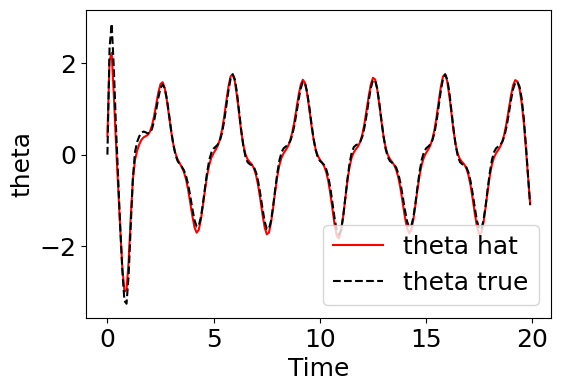

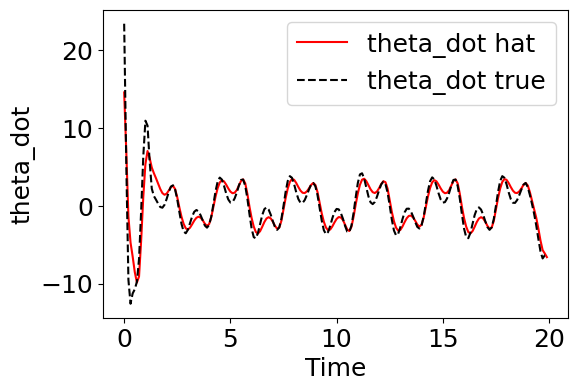

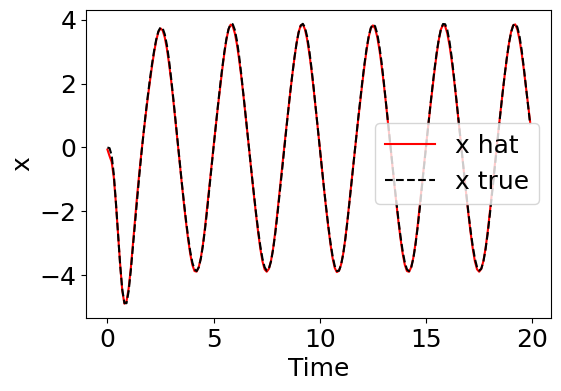

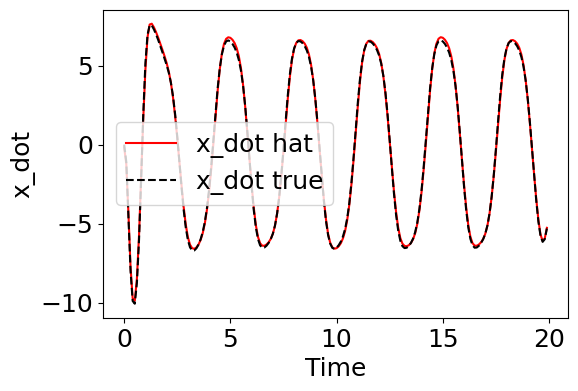

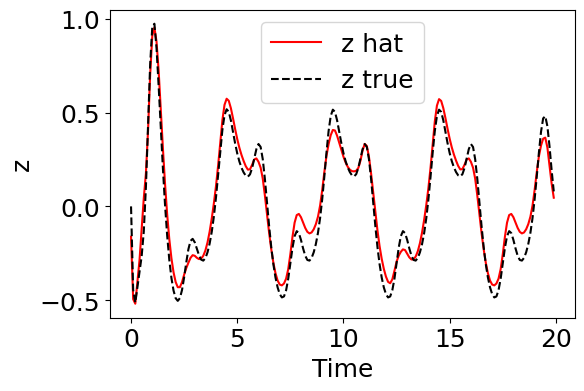

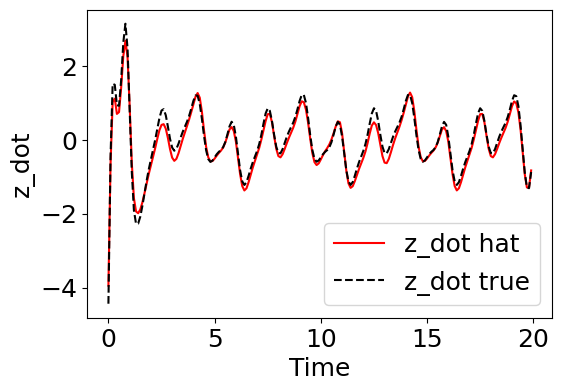

In [23]:
for ix in range(x_sim_df.shape[1]):
    plot_tme(t_sim, true[:,ix], None, pred[:,ix], label_var=x_sim_df.keys()[ix])

### Validate h_ann function

In [39]:
meas = 4

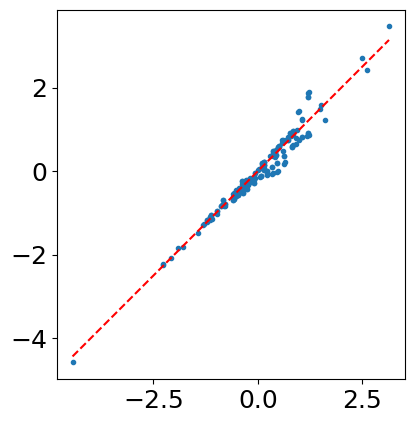

In [40]:
true = []
pred = []

for i in range(len(t_sim)):
    y = h(x_sim_df.values[i], u_sim_df.values[i])
    true.append(y)

    y = h_ann(x_sim_df.values[i], u_sim_df.values[i])
    pred.append(y)

true = np.vstack(true)
pred = np.vstack(pred)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(true[:,meas], pred[:,meas], '.')

l = np.linspace(np.min(true[:, meas]), np.max(true[:,meas]))
plt.plot(l, l, '--', color='red')

ax.set_aspect('equal')

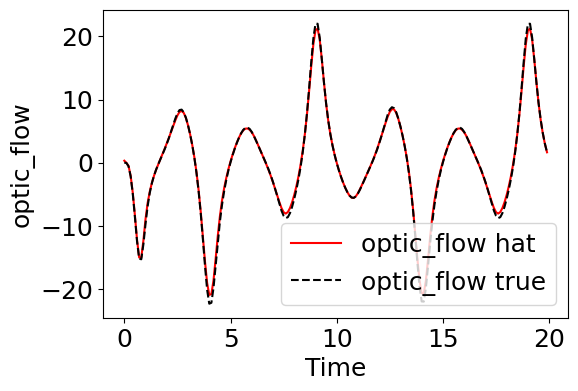

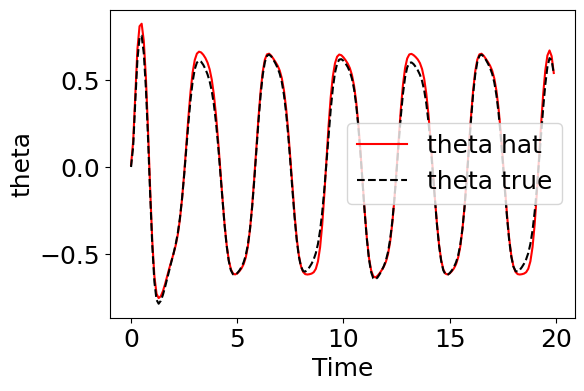

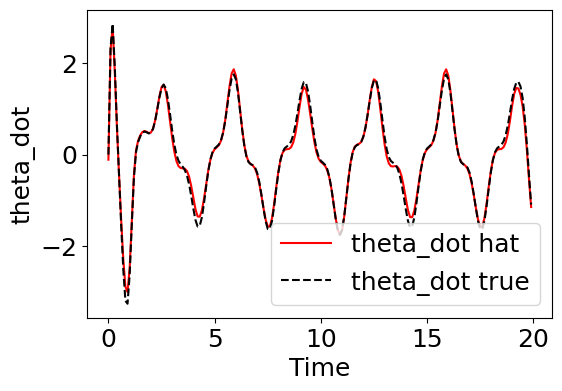

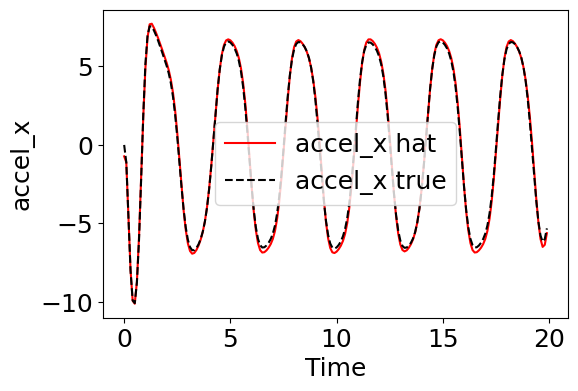

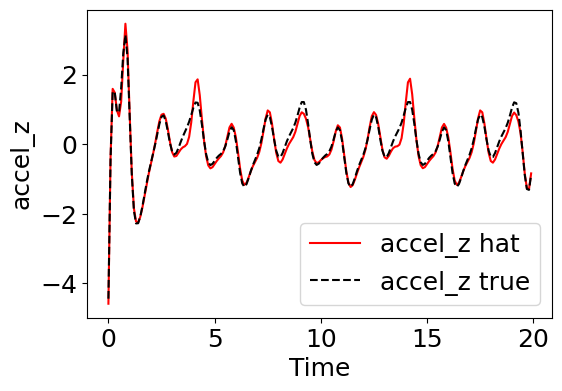

In [41]:
for ix in range(y_noisy_df.shape[1]):
    plot_tme(t_sim, true[:,ix], None, pred[:,ix], label_var=y_noisy_df.keys()[ix])

# Kalman filter parameters and initilization

In [42]:
x0 = np.ones(len(x_sim))*0.5
u0 = np.zeros(2)
P0 = np.eye(len(x_sim))*1e-1

In [43]:
R = np.diag( list(measurement_noise_stds.values()) )**2
Q = np.diag([1e-3]*len(x0))

In [44]:
dt = np.mean(np.diff(t_sim))

# Unscented Kalman Filter

In [45]:
ukf = unscented_kalman_filter.UKF(f_ann, h_ann, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=0.1,
                                 alpha=0.1)

In [46]:
ukf.estimate(y_noisy_df, u_sim_df)

In [47]:
ukf.history.keys()

dict_keys(['X', 'P', 'P_diags', 'sigma_points'])

In [48]:
# State estimate
x_est = pd.DataFrame(np.vstack(ukf.history['X']), columns=f(None,None,return_state_names=True))

In [49]:
# Covariance diagonals
P_diags = np.vstack([np.diag(ukf.history['P'][i]) for i in range(len(ukf.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

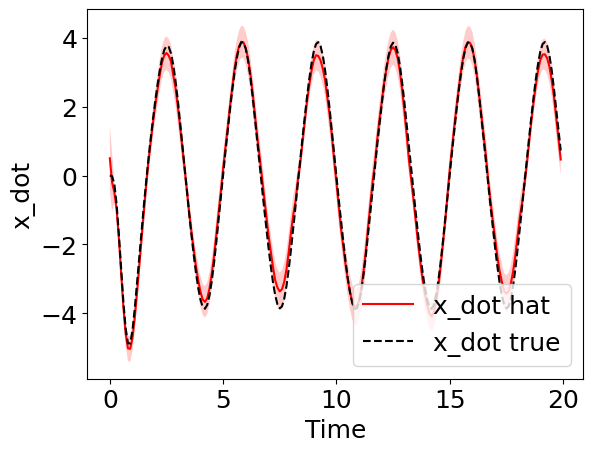

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

(-2.0, 5.0)

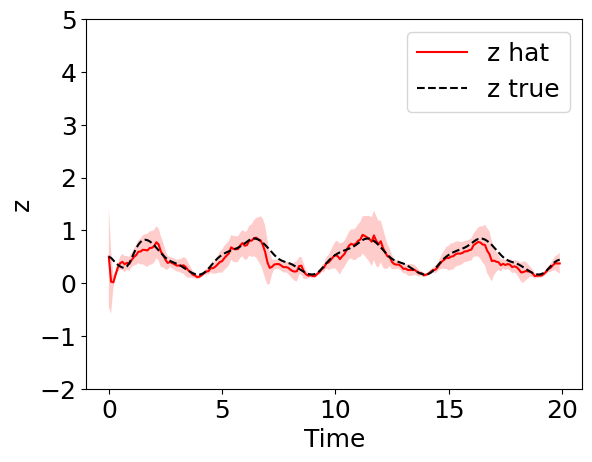

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

ax.set_ylim(-2, 5)